In [38]:
import numpy as np
import pandas as pd
from pandas.api.types import (
  is_object_dtype,
  is_numeric_dtype,
)

import sklearn
from sklearn.preprocessing import (
  MinMaxScaler,
  StandardScaler,
  RobustScaler,
  QuantileTransformer,
)
from sklearn.impute import SimpleImputer
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
  KFold,
  GridSearchCV,
)
from sklearn.metrics import (
  mean_squared_error as mse,
  mean_absolute_error as mae,
)
from sklearn.decomposition import PCA, NMF

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import (
  RandomForestRegressor,
  GradientBoostingRegressor,
)

import seaborn as sns

from model import *

import warnings

sklearn.set_config(transform_output="pandas")
rng = np.random.default_rng(424)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [39]:
# read dataframe according to the provided dtypes
dtypes = pd.read_csv("data/df_dtypes.csv", index_col="Column")
dtypes_dict = dtypes.to_dict()["Dtype"]
df = (
  pd.read_csv(
    "data/df.csv",
    dtype=dtypes_dict,
    # index_col="HouseId",
  )
  .replace({"Другой": pd.NA})
  .drop(columns="HouseId")
)
targ = "SqMeterCost"

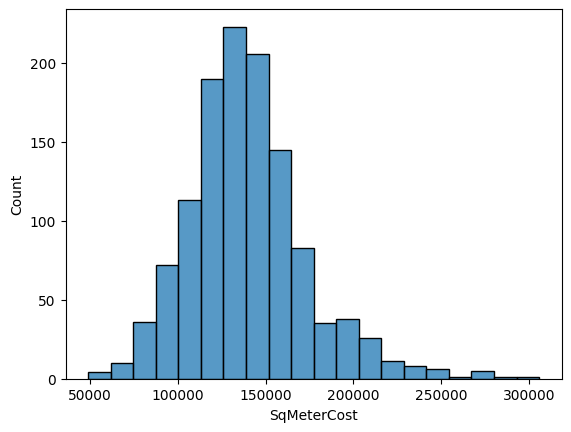

In [40]:
_ = sns.histplot(data=df, x=targ, bins=20)

In [41]:
valid = df[
  (df["Month"].isin(["Июнь", "Июль", "Август"])) & (df["Year"] == 2022)
]
train = df.drop(valid.index)

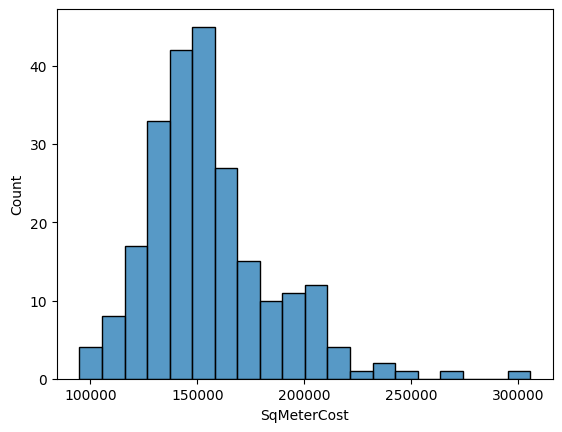

In [42]:
_ = sns.histplot(data=valid, x=targ, bins=20)

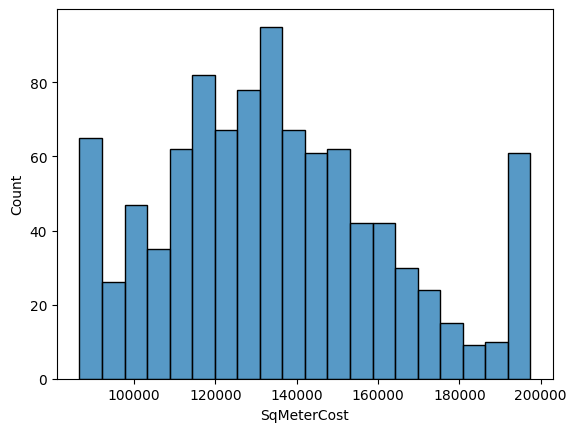

In [43]:
y = train[[targ]]
tail = 0.05
lower = y[targ].quantile(tail)
upper = y[targ].quantile(1 - tail)
y.loc[:, targ] = y.loc[:, targ].apply(
  lambda c: lower if c < lower else upper if c > upper else c
)
_ = sns.histplot(data=y, x=targ, bins=20)

In [44]:
X = train.drop(columns=targ)
if isinstance(y, pd.DataFrame):
  y = y["SqMeterCost"]

numr_cols = X.dtypes[X.dtypes.map(is_numeric_dtype)].index.to_list()
bool_cols_pred = lambda col: X[col].min() == 0 and X[col].max() == 1
bool_cols = list(filter(bool_cols_pred, numr_cols))
numr_cols = list(set(numr_cols) - set(bool_cols))
catg_cols = X.dtypes[X.dtypes.map(is_object_dtype)].index.to_list()

numr_cols.sort()
bool_cols.sort()
catg_cols.sort()
cols = catg_cols + bool_cols + numr_cols
X = X[cols]

In [45]:
minmax_scaler = ColumnTransformer(
  [("scaler", MinMaxScaler(), numr_cols)],
  remainder="passthrough",
  verbose_feature_names_out=False,
)
robust_scaler = ColumnTransformer(
  [("scaler", RobustScaler(), numr_cols)],
  remainder="passthrough",
  verbose_feature_names_out=False,
)

In [46]:
simple_imputer = ColumnTransformer(
  [
    ("mean_imputer", SimpleImputer(strategy="mean"), numr_cols),
    (
      "freq_imputer",
      SimpleImputer(strategy="most_frequent"),
      bool_cols + catg_cols,
    ),
  ],
  remainder="passthrough",
  verbose_feature_names_out=False,
)
numr_imputer = ColumnTransformer(
  [("imputer", MyKNNImputer(bool_cols), numr_cols + bool_cols)],
  remainder="passthrough",
  verbose_feature_names_out=False,
)
turbo_imputer = Pipeline(
  [
    ("numr_imputer", numr_imputer),
    ("catg_imputer", CatgImputer(catg_cols)),
  ]
)

In [47]:
matrl_type_pred = lambda x: x.startswith("Matrl") or x.startswith("Type")
dist_pred = lambda x: x.startswith("Dist")
reach_pred = lambda x: x.startswith("Reach")

short_encoder = ColumnTransformer(
  [
    ("target_encoder", TargetEncoder(), ["HouseCatg", "District"]),
    (
      "binary_encoder",
      BinaryEncoder(),
      list(filter(matrl_type_pred, catg_cols)) + ["Month"],
    ),
    (
      "dropped",
      "drop",
      ["CompanyName", "HouseStat"]
      + list(filter(dist_pred, numr_cols))
      + list(filter(reach_pred, bool_cols)),
    ),
  ],
  remainder="passthrough",
  verbose_feature_names_out=False,
)

long_encoder = ColumnTransformer(
  [
    ("target_encoder", TargetEncoder(), ["HouseCatg"]),
    (
      "binary_encoder",
      BinaryEncoder(),
      list(filter(matrl_type_pred, catg_cols)) + ["Month"],
    ),
    ("dropped", "drop", ["CompanyName", "HouseStat", "District"]),
  ],
  remainder="passthrough",
  verbose_feature_names_out=False,
)

In [48]:
pipeline = Pipeline(
  [
    ("scaling", "passthrough"),
    ("imputing", "passthrough"),
    ("encoding", "passthrough"),
    ("reduction", "passthrough"),
    ("estimator", TransformedTargetRegressor()),
  ]
)

param_grid = [
  {
    "scaling": [
      minmax_scaler,
      robust_scaler,
    ],
    "imputing": [
      simple_imputer,
      turbo_imputer,
    ],
    "encoding": [
      short_encoder,
      long_encoder,
    ],
    "reduction": [
      PCA(),
    ],
    "reduction__n_components": [
      10,
      25,
      40,
    ],
    "estimator__transformer": [
      PassthroughTransformer(),
      LogarithmicTransformer(),
      QuantileTransformer(n_quantiles=20),
    ],
    "estimator__regressor": [
      Ridge(),
      RandomForestRegressor(),
      GradientBoostingRegressor(),
    ],
  }
]

grid = GridSearchCV(pipeline, param_grid=param_grid)
grid.fit(X, y)

/home/makcymal/miniconda3/envs/pyenv/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but QuantileTransformer was fitted without feature names
  warnings.warn(
/home/makcymal/miniconda3/envs/pyenv/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but QuantileTransformer was fitted without feature names
  warnings.warn(
/home/makcymal/miniconda3/envs/pyenv/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but QuantileTransformer was fitted without feature names
  warnings.warn(
/home/makcymal/miniconda3/envs/pyenv/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but QuantileTransformer was fitted without feature names
  warnings.warn(
/home/makcymal/miniconda3/envs/pyenv/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but QuantileTransformer was fitted without feature names
  warnings.warn(
/home/makcymal/miniconda3

KeyboardInterrupt: 

In [ ]:
grid.best_score_

0.3609397528712913

In [ ]:
grid.best_estimator_

Pipeline(steps=[('scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['AreaCommPremises',
                                                   'AreaFlatsTtl',
                                                   'AreaLandPlot',
                                                   'AreaPlaygrounds',
                                                   'AreaSpecGrounds',
                                                   'AreaSportgrounds',
                                                   'CeilHeight', 'DistArtem',
                                                   'DistBalyaeva', 'DistCenter',
                                                   'DistClosestHouse',
                                                   'DistDvfu', 'DistLugovaya',
                                                   'DistOkatovaya',
                                                   'DistPervayaRechka',
                                                   'Di...
                                                  ['HouseCatg']),
                                                 ('binary_encoder',
                                                  BinaryEncoder(),
                                                  ['MatrlFacadeAuxl',
                                                   'MatrlFacadeMain',
                                                   'TypeFacade', 'TypeHouse',
                                                   'Month']),
                                                 ('dropped', 'drop',
                                                  ['CompanyName', 'HouseStat',
                                                   'District'])],
                                   verbose_feature_names_out=False)),
                ('reduction', PCA(n_components=25)),
                ('estimator',
                 TransformedTargetRegressor(regressor=Ridge(),
                                            transformer=QuantileTransformer(n_quantiles=20)))])

In [ ]:
if "SqMeterCost" in valid.columns:
  y_true = valid.pop("SqMeterCost")
y_pred = grid.predict(valid)
mae(y_true, y_pred)

19221.87374415778

In [ ]:
pipeline_ = Pipeline(
  [
    ("scaling", "passthrough"),
    ("imputing", "passthrough"),
    ("encoding", "passthrough"),
    ("reduction", "passthrough"),
    ("estimator", TransformedTargetRegressor()),
  ]
)

param_grid_ = [
  {
    "scaling": [
      minmax_scaler,
    ],
    "imputing": [
      turbo_imputer,
    ],
    "encoding": [
      long_encoder,
    ],
    "reduction": [
      PCA(),
    ],
    "reduction__n_components": [
      25,
    ],
    "estimator__transformer": [
      PassthroughTransformer(),
      LogarithmicTransformer(),
    ],
    "estimator__regressor": [
      Ridge(),
      RandomForestRegressor(),
      GradientBoostingRegressor(),
    ],
  }
]

grid_ = GridSearchCV(pipeline_, param_grid=param_grid_)
grid_.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('scaling', 'passthrough'),
                                       ('imputing', 'passthrough'),
                                       ('encoding', 'passthrough'),
                                       ('reduction', 'passthrough'),
                                       ('estimator',
                                        TransformedTargetRegressor())]),
             param_grid=[{'encoding': [ColumnTransformer(remainder='passthrough',
                                                         transformers=[('target_encoder',
                                                                        TargetEncoder(),
                                                                        ['HouseCatg']),
                                                                       ('binary_encoder',
                                                                        BinaryEnco...
                                                                        'DistClosestHouse',
                                                                        'DistDvfu',
                                                                        'DistLugovaya',
                                                                        'DistOkatovaya',
                                                                        'DistPervayaRechka',
                                                                        'DistTretyaRabochaya',
                                                                        'DistVolnoNad',
                                                                        'DistVtorayaRechka',
                                                                        'HeightLocal',
                                                                        'HeightMaxNrby',
                                                                        'HeightMinNrby',
                                                                        'InfrGrocery',
                                                                        'InfrKindergartens',
                                                                        'InfrMedicine',
                                                                        'InfrMolls',
                                                                        'InfrNewHouses',
                                                                        'InfrSchools',
                                                                        'InfrSports',
                                                                        'InfrSupermarkets',
                                                                        'InfrTransport', ...])],
                                                        verbose_feature_names_out=False)]}])

In [ ]:
grid_.best_score_

0.34020023032467844

In [ ]:
grid_.best_estimator_

Pipeline(steps=[('scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['AreaCommPremises',
                                                   'AreaFlatsTtl',
                                                   'AreaLandPlot',
                                                   'AreaPlaygrounds',
                                                   'AreaSpecGrounds',
                                                   'AreaSportgrounds',
                                                   'CeilHeight', 'DistArtem',
                                                   'DistBalyaeva', 'DistCenter',
                                                   'DistClosestHouse',
                                                   'DistDvfu', 'DistLugovaya',
                                                   'DistOkatovaya',
                                                   'DistPervayaRechka',
                                                   'Di...
                                                  TargetEncoder(),
                                                  ['HouseCatg']),
                                                 ('binary_encoder',
                                                  BinaryEncoder(),
                                                  ['MatrlFacadeAuxl',
                                                   'MatrlFacadeMain',
                                                   'TypeFacade', 'TypeHouse',
                                                   'Month']),
                                                 ('dropped', 'drop',
                                                  ['CompanyName', 'HouseStat',
                                                   'District'])],
                                   verbose_feature_names_out=False)),
                ('reduction', PCA(n_components=25)),
                ('estimator',
                 TransformedTargetRegressor(regressor=Ridge(),
                                            transformer=PassthroughTransformer()))])

In [ ]:
y_pred = grid_.predict(valid)
mae(y_true, y_pred)

19420.290504864435